In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time

In [2]:
import cifar_pre_process
dt = cifar_pre_process.CifarPreProcess()
dt.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


# Import network, layers and functions

In [3]:
from nnet.network import Sequential
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,BatchNormalization
from nnet import optimizers
from nnet import functions
import numpy as np

Seed: 52
Seed: 668


In [4]:
# np.random.seed()

# Make Sequential Model

In [5]:
model=Sequential()

In [6]:
model.add(conv2d(num_kernels=32,kernel_size=3,activation=functions.relu,input_shape=(32,32,3)))
# model.add(conv2d(num_kernels=32,kernel_size=3,activation=functions.relu))
model.add(BatchNormalization())
model.add(max_pool())
model.add(dropout(0.1))
model.add(conv2d(num_kernels=64,kernel_size=3,activation=functions.relu))
# model.add(conv2d(num_kernels=64,kernel_size=3,activation=functions.relu))
model.add(BatchNormalization())
model.add(max_pool())
model.add(dropout(0.2))
model.add(conv2d(num_kernels=128,kernel_size=3,activation=functions.relu))
# model.add(conv2d(num_kernels=128,kernel_size=3,activation=functions.relu))
model.add(BatchNormalization())
model.add(max_pool())
model.add(dropout(0.3))
model.add(flatten())
model.add(dense(512,activation=functions.relu))
model.add(BatchNormalization())
model.add(dropout(0.4))
model.add(dense(10,activation=functions.softmax))

# View Model Summary

In [7]:
model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
input_layer (InputLayer)  (None, 32, 32, 3)          echo             0
__________________________________________________________________________________________
conv2d (conv2d)           (None, 32, 32, 32)         relu             896
__________________________________________________________________________________________
BatchNormalization (Batch (None, 32, 32, 32)         echo             128
__________________________________________________________________________________________
max_pool (max_pool)       (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
dropout (dropout)         (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
conv2d (conv

# Compile model with optimizer, loss and lr

In [8]:
model.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.001)

# Reload saved model weights

In [9]:
# model.load_weights("cifar.dump")

# Train model

In [10]:
losses=[]
train_acc=[]

In [11]:
def validate(vdsz=128):
    dvme=len(dt.test_images)//vdsz
    acc=0
    cross_entropy_loss=0
    for smpl in range(0,len(dt.test_images),vdsz):
        print("\rCalculating Validation acc...",dvme-smpl//vdsz,end=' ')
        inp = dt.test_images[smpl:smpl+vdsz].reshape(-1,32,32,3)
        y_inp = dt.test_labels[smpl:smpl+vdsz]
        logits=model.predict(inp)
        ans=logits.argmax(axis=1)
        cor=y_inp.argmax(axis=1)
        acc+=100*(ans==cor).mean()
        cross_entropy_loss+=model.loss(logits,labels=y_inp).mean()*10
    print("\rValidation Acc: {:.3f} %        Val loss: {:.8f}".format(acc/dvme,cross_entropy_loss/dvme))
    model.free()

In [12]:
def run():
    st=0
    btsz=128
    acc_tn=0
    _cc=0
    loss_tn=0
    pre_tm=0
    while st<=50000:
        sam_tm=time()
        perc=st/500
        ck=np.random.randint(0,50000-btsz)
        inp,y_inp=dt.batch_gen(ck=ck,size=btsz)
        logits=model.fit(inp,y_inp)
        ans=logits.argmax(axis=1)
        cor=y_inp.argmax(axis=1)
        acc=100*(ans==cor).mean()
        cross_entropy_loss=model.loss(logits=logits,labels=y_inp).mean()*10
        acc_tn+=acc
        _cc+=1
        loss_tn+=cross_entropy_loss
        acc=acc_tn/_cc
        loss_=loss_tn/_cc
        losses.append(loss_)
        train_acc.append(acc)
#         if acc>=85:
#             model.learning_rate=1e-4/2
#         elif acc>=79:
#             model.learning_rate=1e-4
#         elif acc>=62:
#             model.learning_rate=1e-4
        sam_tm=time()-sam_tm
        pre_tm+=sam_tm
        sam_tm=pre_tm/_cc
        rem_sam=(50000-st)/btsz
        eta=int(rem_sam*sam_tm)
        print("\rProgress: {:.2f} %    Acc: {:.3f} %    loss: {:.6f}     Sample time: {:.3f}s    ETA: {}:{}s    _".format(perc,acc,loss_,sam_tm,eta//60,eta%60),end='')
        st+=btsz
    print("")

In [25]:
epochs=4     #adam
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 46.034 %    loss: 1.643566     Sample time: 0.825s    ETA: 0:0s    __
Epoch time: 5:22s
Validation Acc: 55.990 %        Val loss: 2.90318107
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 56.706 %    loss: 1.238205     Sample time: 0.855s    ETA: 0:0s    __
Epoch time: 5:34s
Validation Acc: 58.484 %        Val loss: 3.03902073
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 61.151 %    loss: 1.106273     Sample time: 0.852s    ETA: 0:0s    __
Epoch time: 5:33s
Validation Acc: 64.413 %        Val loss: 2.07362350
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 64.408 %    loss: 1.011426     Sample time: 0.917s    ETA: 0:0s    __
Epoch time: 5:58s
Validation Acc: 66.927 %        Val loss: 2.07156822


In [25]:
epochs=4     #adam
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 46.034 %    loss: 1.643566     Sample time: 0.825s    ETA: 0:0s    __
Epoch time: 5:22s
Validation Acc: 55.990 %        Val loss: 2.90318107
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 56.706 %    loss: 1.238205     Sample time: 0.855s    ETA: 0:0s    __
Epoch time: 5:34s
Validation Acc: 58.484 %        Val loss: 3.03902073
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 61.151 %    loss: 1.106273     Sample time: 0.852s    ETA: 0:0s    __
Epoch time: 5:33s
Validation Acc: 64.413 %        Val loss: 2.07362350
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 64.408 %    loss: 1.011426     Sample time: 0.917s    ETA: 0:0s    __
Epoch time: 5:58s
Validation Acc: 66.927 %        Val loss: 2.07156822


In [12]:
epochs=4     #adamax
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 50.991 %    loss: 1.442748     Sample time: 0.972s    ETA: 0:0s    __
Epoch time: 6:20s
Validation Acc: 20.102 %        Val loss: 48.20534981
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 64.340 %    loss: 1.005628     Sample time: 1.064s    ETA: 0:0s    __
Epoch time: 6:56s
Validation Acc: 53.095 %        Val loss: 2.24658271
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 69.271 %    loss: 0.871967     Sample time: 0.835s    ETA: 0:0s    __
Epoch time: 5:26s
Validation Acc: 67.097 %        Val loss: 1.79537575
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 72.552 %    loss: 0.776094     Sample time: 0.885s    ETA: 0:0s    __
Epoch time: 5:46s
Validation Acc: 65.935 %        Val loss: 2.71965415


In [12]:
epochs=4     #rmsprop
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 45.882 %    loss: 1.677551     Sample time: 1.166s    ETA: 0:0s    __
Epoch time: 7:36s
Validation Acc: 56.921 %        Val loss: 2.75604812
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 60.280 %    loss: 1.133654     Sample time: 1.022s    ETA: 0:0s    __
Epoch time: 6:39s
Validation Acc: 59.335 %        Val loss: 1.75677510
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 66.422 %    loss: 0.952361     Sample time: 1.009s    ETA: 0:0s    __
Epoch time: 6:34s
Validation Acc: 64.804 %        Val loss: 1.60932669
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 70.271 %    loss: 0.845278     Sample time: 1.130s    ETA: 0:0s    __
Epoch time: 7:21s
Validation Acc: 65.054 %        Val loss: 1.68165744


In [28]:
epochs=4     #momentum wih weight decay
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 38.119 %    loss: 1.753952     Sample time: 0.858s    ETA: 0:0s    __
Epoch time: 5:35s
Validation Acc: 48.037 %        Val loss: 1.88160131
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 50.190 %    loss: 1.390724     Sample time: 0.895s    ETA: 0:0s    __
Epoch time: 5:50s
Validation Acc: 56.991 %        Val loss: 1.62586406
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 55.001 %    loss: 1.257747     Sample time: 0.826s    ETA: 0:0s    __
Epoch time: 5:23s
Validation Acc: 60.026 %        Val loss: 1.44985205
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 58.802 %    loss: 1.150044     Sample time: 0.805s    ETA: 0:0s    __
Epoch time: 5:14s
Validation Acc: 61.889 %        Val loss: 1.36618657


In [12]:
epochs=4           #momentum without weight decay
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 38.047 %    loss: 1.752285     Sample time: 0.841s    ETA: 0:0s    __
Epoch time: 5:28s
Validation Acc: 51.522 %        Val loss: 1.94979205
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 49.291 %    loss: 1.403237     Sample time: 0.827s    ETA: 0:0s    __
Epoch time: 5:23s
Validation Acc: 53.756 %        Val loss: 1.93978226
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 54.927 %    loss: 1.264855     Sample time: 0.861s    ETA: 0:0s    __
Epoch time: 5:36s
Validation Acc: 59.175 %        Val loss: 1.61854286
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 57.822 %    loss: 1.176735     Sample time: 0.860s    ETA: 0:0s    __
Epoch time: 5:36s
Validation Acc: 61.398 %        Val loss: 1.65666200


In [28]:
epochs=4     #adagrad
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 46.879 %    loss: 1.585103     Sample time: 0.901s    ETA: 0:0s    __
Epoch time: 5:52s
Validation Acc: 57.181 %        Val loss: 2.22272900
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 56.324 %    loss: 1.237976     Sample time: 0.946s    ETA: 0:0s    __
Epoch time: 6:9s
Validation Acc: 59.024 %        Val loss: 3.07875839
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 60.042 %    loss: 1.117470     Sample time: 0.830s    ETA: 0:0s    __
Epoch time: 5:24s
Validation Acc: 59.696 %        Val loss: 3.59386949
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 62.692 %    loss: 1.052007     Sample time: 0.823s    ETA: 0:0s    __
Epoch time: 5:21s
Validation Acc: 60.587 %        Val loss: 3.47717820


In [12]:
epochs=4     #adadelta
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 35.132 %    loss: 2.146440     Sample time: 0.888s    ETA: 0:0s    __
Epoch time: 5:47s
Validation Acc: 48.107 %        Val loss: 3.59379339
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 47.149 %    loss: 1.584790     Sample time: 0.956s    ETA: 0:0s    __
Epoch time: 6:13s
Validation Acc: 53.035 %        Val loss: 3.13506526
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 54.078 %    loss: 1.340138     Sample time: 0.882s    ETA: 0:0s    __
Epoch time: 5:44s
Validation Acc: 59.155 %        Val loss: 2.51796225
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 57.529 %    loss: 1.221401     Sample time: 0.901s    ETA: 0:0s    __
Epoch time: 5:52s
Validation Acc: 59.696 %        Val loss: 2.96834864


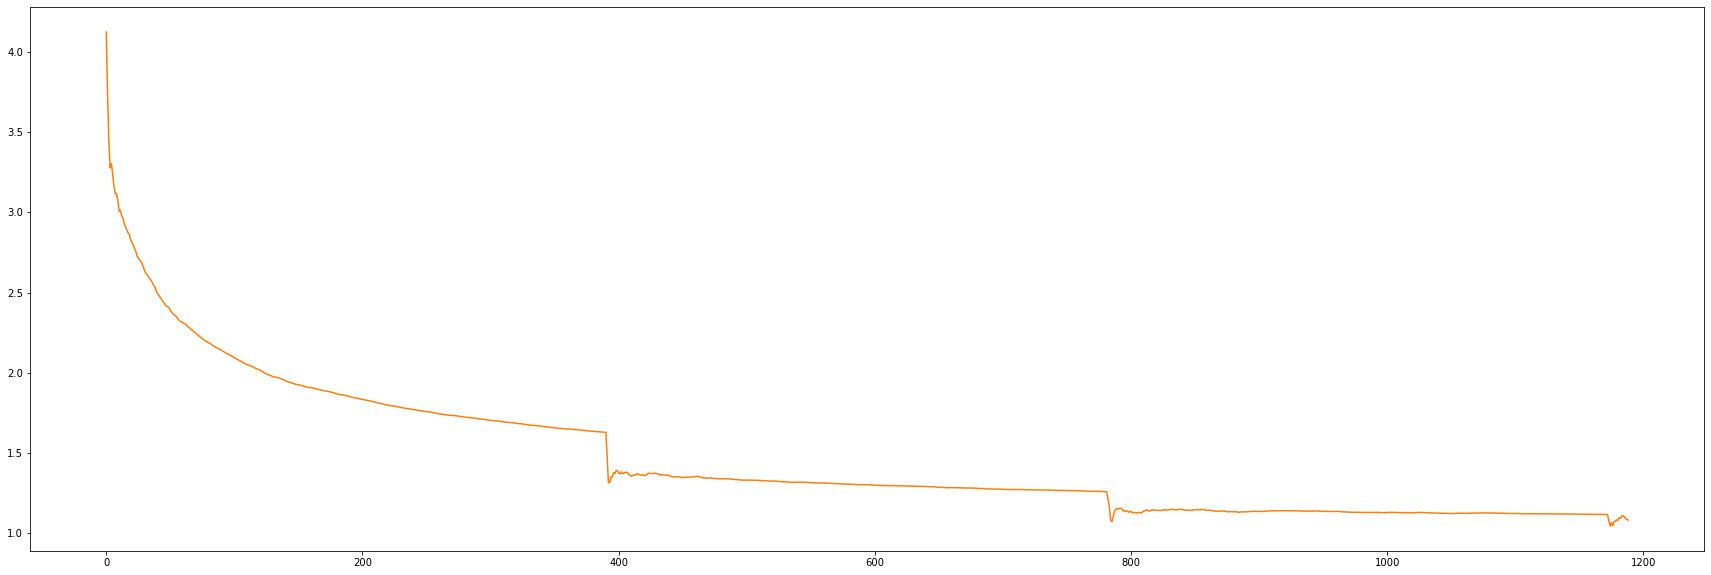

In [15]:
plt.figure(figsize=(30,10))
plt.plot(losses,color='#ff7f0e')
plt.show()

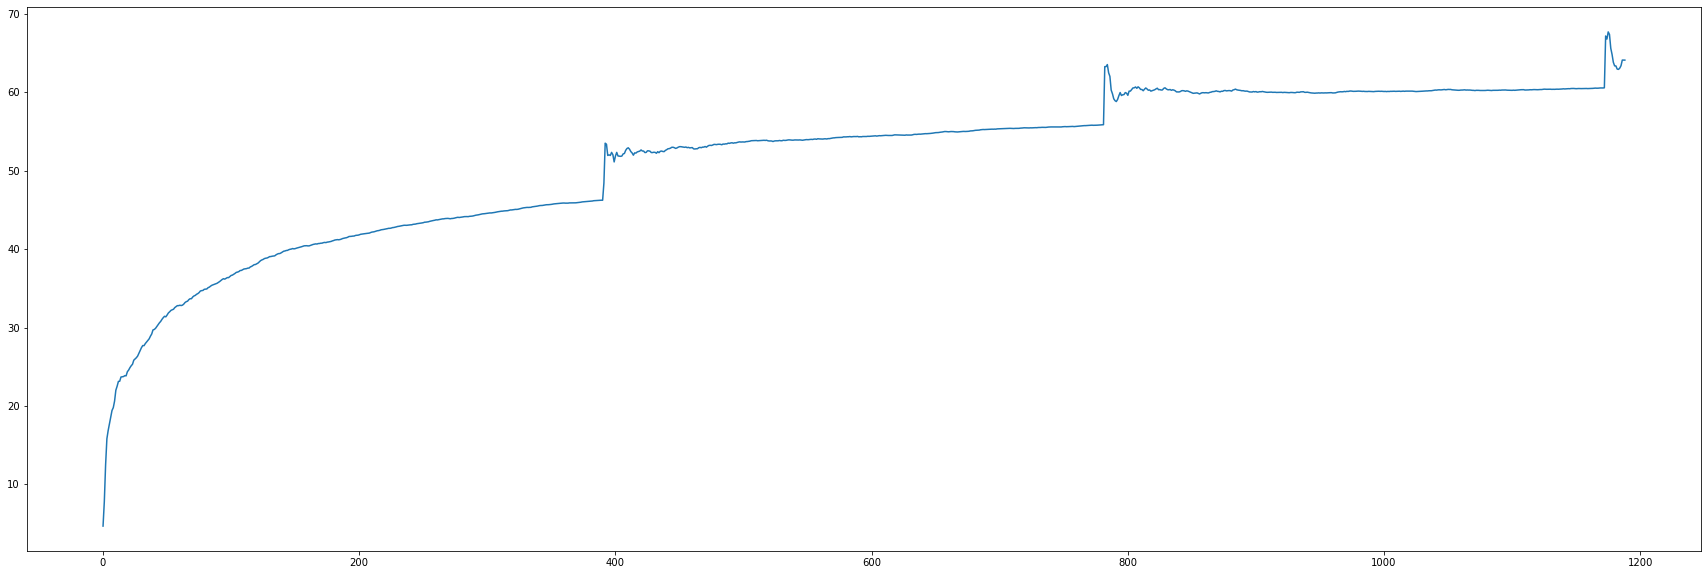

In [16]:
plt.figure(figsize=(30,10))
plt.plot(train_acc)#,color='#ff7f0e')
plt.show()

In [134]:
model.save_weights("cifar.dump")

Prediction:  automobile 
Correct answer:  automobile


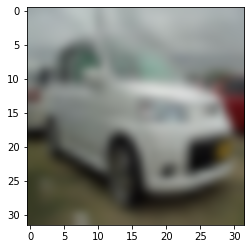

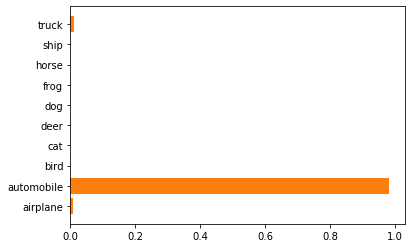

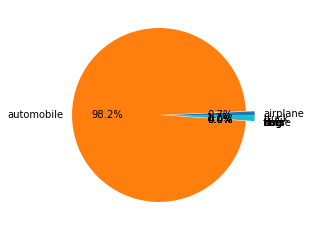

In [58]:
ck=np.random.randint(0,10000)
# inp,y_inp=dt.batch_gen(size=1,ck=ck)
inp = dt.test_images[ck:ck+1].reshape(-1,32,32,3)
y_inp = dt.test_labels[ck:ck+1]
logits=model.predict(inp)
ans=logits.argmax(axis=1)
cor=y_inp.argmax(axis=1)
logits=logits[0]
print("Prediction: ",dt.names[int(ans[0])],"\nCorrect answer: ",dt.names[int(cor[0])])
plt.imshow(inp[0],interpolation='bicubic')
plt.show()
plt.barh(range(len(logits)),logits,color='#ff7f0e')
plt.yticks(range(len(logits)),dt.names)
# plt.xticks([])
plt.show()
explode=np.zeros(10)
explode[ans]=0.1
plt.pie(logits,labels=dt.names,autopct='%1.1f%%',explode=explode)
plt.show()

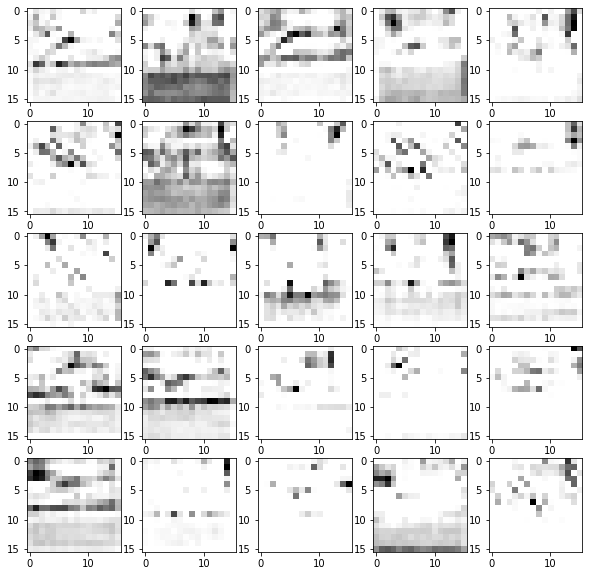

In [25]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
pme=model.sequence[4].z_out[0].transpose(2,0,1)
for i,axi in enumerate(ax.flat):
    axi.imshow(pme[i].reshape(pme.shape[-2:]), cmap='Greys')

In [145]:
import cv2
import os

Prediction:  dog


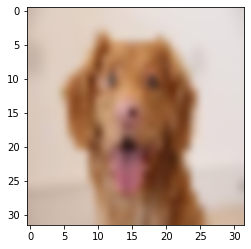

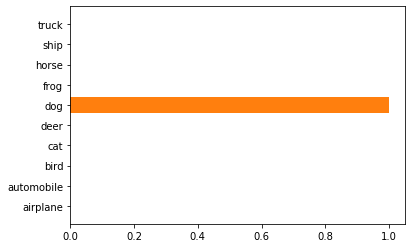

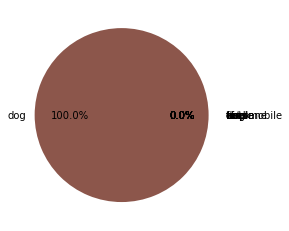

In [182]:
img=cv2.imread("download.jpeg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
inp=cv2.resize(img,(32,32),interpolation=cv2.INTER_CUBIC).reshape(-1,32,32,3)
logits=model.predict(inp)
ans=logits.argmax(axis=1)
logits=logits[0]
print("Prediction: ",dt.names[int(ans[0])])
plt.imshow(inp[0],interpolation='bicubic')
plt.show()
plt.barh(range(len(logits)),logits,color='#ff7f0e')
plt.yticks(range(len(logits)),dt.names)
# plt.xticks([])
plt.show()
explode=np.zeros(10)
explode[ans]=0.1
plt.pie(logits,labels=dt.names,autopct='%1.1f%%',explode=explode)
plt.show()